<a href="https://colab.research.google.com/github/amrutha2413/Logistic-Regression/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Successfully read CSV with separator: ';'
Columns read: ['Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH']
Successfully read CSV with separator: ','
Columns read: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Final parameters (w):
[ 0.14782423  0.63649816  1.8788692   1.98872061  1.29591378  0.08589362
  0.40732822  0.98198514 -0.06813439 -0.64842474 -0.06792392 -0.47503644]
Training accuracy: 0.9314


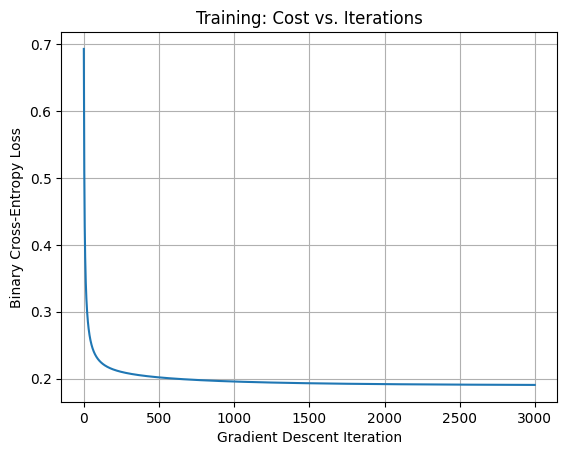

Plotting cost sensitivity for parameter indices: [3 2 4]


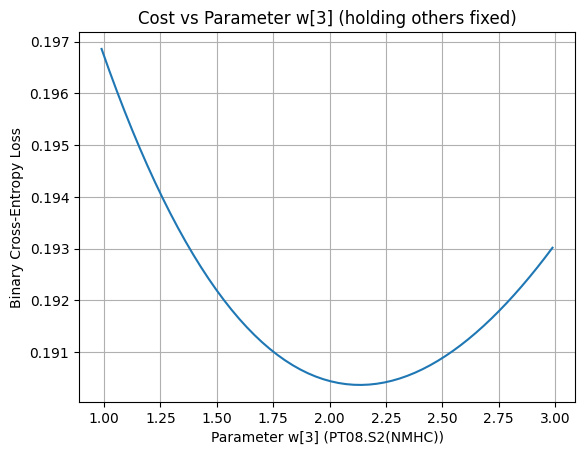

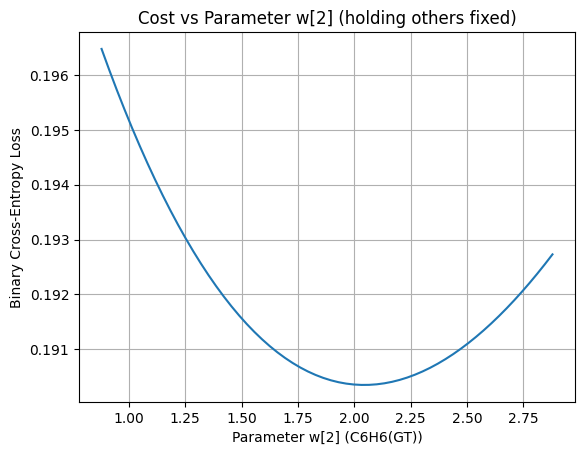

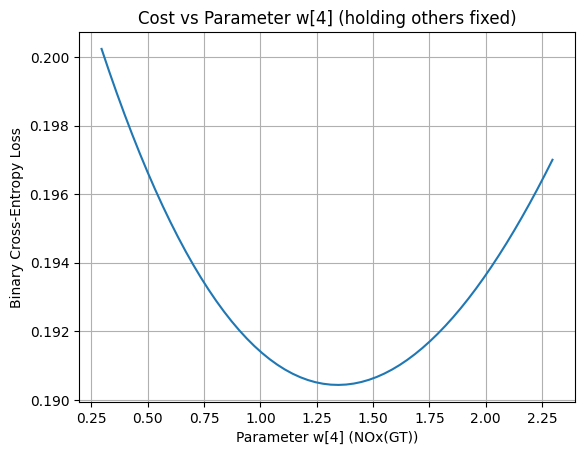

In [ ]:
# ================================
# Logistic Regression (from scratch) — Air Quality
# ================================

# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 1) Load / prepare data
# --------------------------------------------------
def load_data(
    csv_path="/content/sample_data/Air_Quality - Sheet1.csv",
    threshold_co=2.0,         # label: 1 if CO(GT) > threshold_co else 0
    feature_cols=None,
    random_state=42,
):
    """
    Loads AirQualityUCI.csv, cleans it, selects features, creates a binary label:
      y = 1 if CO(GT) > threshold_co else 0

    Returns:
      X: (m, n) numpy array (standardized)
      y: (m,) numpy array {0,1}
      feature_cols: list[str] used feature names
    """

    # Read with the common UCI separators/decimal
    separators = [';', ',', '\t', ' ']
    df = None
    for sep in separators:
        try:
            df = pd.read_csv(csv_path, sep=sep, decimal=",", encoding="utf-8", low_memory=False)
            print(f"Successfully read CSV with separator: '{sep}'")
            print("Columns read:", list(df.columns))
            if len(df.columns) > 1:
                break
            else:
                df = None
        except Exception:
            pass

    if df is None:

         for sep in separators:
            try:
                df = pd.read_csv(csv_path, sep=sep, encoding="utf-8", low_memory=False)
                print(f"Successfully read CSV with separator: '{sep}' (no decimal specified)")
                print("Columns read:", list(df.columns))
                if len(df.columns) > 1: # check if it was read as multiple columns
                    break
                else:
                    df = None # If only one column, try next separator
            except Exception:
                pass

    if df is None:
        raise Exception("Could not read CSV with any of the common separators.")


    # Normalize header names (trim spaces, remove BOM if any)
    df.columns = (
        df.columns
        .str.replace("\ufeff", "", regex=False)
        .str.strip()
    )

    # Drop junk padding columns
# drop columns here p and q
    # Convert non-date/time columns to numeric where possible
    for c in df.columns:
        if c not in ("Date", "Time"):
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Replace dataset's missing code (-200) with NaN
    df = df.replace(-200, np.nan)

    # Default features if none provided
    if feature_cols is None:
        feature_cols = [
            "PT08.S1(CO)",   # Tin oxide sensor
            "C6H6(GT)",      # Benzene (ug/m^3)
            "PT08.S2(NMHC)", # Non-methane hydrocarbons sensor
            "NOx(GT)",       # NOx concentration (ppb)
            "PT08.S3(NOx)",  # NOx sensor
            "NO2(GT)",       # NO2 concentration (ug/m^3)
            "PT08.S4(NO2)",  # NO2 sensor
            "PT08.S5(O3)",   # O3 sensor
            "T",             # Temperature
            "RH",            # Relative Humidity
            "AH",            # Absolute Humidity
        ]

    # Validate required columns
    required = set(feature_cols + ["CO(GT)"])
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing expected columns in CSV: {missing}\nAvailable: {list(df.columns)}")

    # Keep only needed columns and drop rows with any NaNs
    df = df[feature_cols + ["CO(GT)"]].dropna(axis=0, how="any")

    # Binary label
    y = (df["CO(GT)"].values > threshold_co).astype(int)

    # Features
    X = df[feature_cols].values.astype(float)

    # Standardize features
    #methods for scaling in training models
    eps = 1e-12
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True) + eps
    X = (X - mean) / std

    # Shuffle
    rng = np.random.default_rng(random_state)
    idx = rng.permutation(len(y))
    X, y = X[idx], y[idx]

    return X, y, feature_cols


# Load data
X, y, feature_cols = load_data()
m, n = X.shape

# Add bias column (x0 = 1)
#Bias column is used to make sure the line does not go thru just the origin --> makes it more accurate
X = np.column_stack([np.ones(m), X])  # (m, n+1)
n_with_bias = X.shape[1]

# 2) Utility functions
# --------------------------------------------------
def sigmoid(z):
    z = np.clip(z, -500, 500)  # numerical stability
    return 1.0 / (1.0 + np.exp(-z))

def predict_proba(X, w):
    return sigmoid(X @ w)

def binary_cross_entropy(y_true, y_prob, eps=1e-12):
    p = np.clip(y_prob, eps, 1.0 - eps)
    return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

def gradient(X, y_true, y_prob):
    m = y_true.shape[0]
    return (X.T @ (y_prob - y_true)) / m


# 3) Initialize parameters
# --------------------------------------------------
w = np.zeros(n_with_bias)  # w[0] is bias


# 4) Hyperparameters
# --------------------------------------------------
learning_rate = 0.1
num_iterations = 3000

cost_history = []


# 5) Gradient Descent
# --------------------------------------------------
for _ in range(num_iterations):
    y_hat = predict_proba(X, w)
    cost = binary_cross_entropy(y, y_hat)
    cost_history.append(cost)
    grad = gradient(X, y, y_hat)
    w -= learning_rate * grad


# 6) Final parameters
# --------------------------------------------------
print("Final parameters (w):")
print(w)
preds = (predict_proba(X, w) >= 0.5).astype(int)
acc = (preds == y).mean()
print(f"Training accuracy: {acc:.4f}")


# 7) Plot: Cost vs Iterations
# --------------------------------------------------
plt.figure()
plt.plot(range(len(cost_history)), cost_history)
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training: Cost vs. Iterations")
plt.grid(True)
plt.show()


# 8) Plot: Cost vs 3 of the most important parameters
# --------------------------------------------------
param_indices = np.argsort(np.abs(w[1:]))[::-1][:3] + 1  # skip bias
print("Plotting cost sensitivity for parameter indices:", param_indices)

def compute_cost_given_w(mod_w):
    y_hat_mod = predict_proba(X, mod_w)
    return binary_cross_entropy(y, y_hat_mod)

for idx in param_indices:
    center = w[idx]
    sweep = np.linspace(center - 1.0, center + 1.0, 60)
    costs = []
    for val in sweep:
        w_tmp = w.copy()
        w_tmp[idx] = val
        costs.append(compute_cost_given_w(w_tmp))
    plt.figure()
    label = feature_cols[idx-1] if 1 <= idx <= len(feature_cols) else "bias"
    plt.plot(sweep, costs)
    plt.xlabel(f"Parameter w[{idx}] ({label})")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.title(f"Cost vs Parameter w[{idx}] (holding others fixed)")
    plt.grid(True)
    plt.show()


# 9) Inference helper
# --------------------------------------------------
def predict_label(X_new_no_bias, w, threshold=0.5):
    X_new = np.column_stack([np.ones(X_new_no_bias.shape[0]), X_new_no_bias])
    return (predict_proba(X_new, w) >= threshold).astype(int)